In [1]:
import codecs
import re
import nltk
import collections
import numpy as np
import subprocess
import json
import multiprocessing
import os
import gc
import sklearn
import networkx as nx
import scipy
import metric_learn
import itertools
import pandas as pd
import pandas
from IPython.display import display, HTML
import time
import datetime
from ipywidgets import IntProgress, Label, Layout
from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
from nltk import ngrams

pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 50)

In [2]:
%run shared.py

In [5]:
import sqlite3
sql_conn = sqlite3.connect('books.db')

In [6]:
c = sql_conn.cursor()

In [5]:
mfw_with_count = list(c.execute("""select lex, count(*) as ct from words 
  where lex is not null
  group by lex
  order by ct desc
  limit 500"""))

In [6]:
mfw, _ = zip(*mfw_with_count)
# mfw_map = {w : np.eye(len(mfw), dtype=np.float32)[i] for i, w in enumerate(mfw)}


In [7]:
def get_chunk_mfw(chunk_id, chunk_size):
    
    data = c.execute("""select lex, count(*) * 1.0 / (select count(*) as ct
        from words w
        inner join chunks_%s c on w.id between begin and end
        where c.id = '%s' and lex is not null) as ct
        from words w
        inner join chunks_%s c on w.id between begin and end
        where c.id = '%s' and lex in (%s)
        group by lex
        """ % (chunk_size, chunk_id, chunk_size, chunk_id, ",".join(["'%s'"%w for w in mfw])))
    d = dict(data)
    d["chunk_id"] = chunk_id
    return d

def get_chunks_mfw(chunk_size):
    chunk_ids = list(c.execute("select id from chunks_%s" % chunk_size))
    return pd.DataFrame([get_chunk_mfw(chunk_id, chunk_size) for chunk_id, in progressify_list(chunk_ids)], columns=["chunk_id"] + list(mfw))

chunks_mfw_100000 = get_chunks_mfw(100000)

In [8]:
chunks_mfw_50000 = get_chunks_mfw(50000)

In [9]:
chunks_mfw_100000.drop(["chunk_id"], axis=1).to_csv('mfw_freq_100000_all_chunks.csv', header=False, index=False, sep='\t')
chunks_mfw_50000.drop(["chunk_id"], axis=1).to_csv('mfw_freq_50000_all_chunks.csv', header=False, index=False, sep='\t')

In [11]:
list(c.execute("""select count(*) from chunks_100000"""))

[(2111,)]

In [14]:
len(get_chunk_descriptions(100000))

2111

In [7]:

def get_chunk_descriptions(chunk_size):
    df = pd.DataFrame(list(c.execute("""select b.name, b.author, a.name, b.id, c.id from chunks_%s c
        inner join words w on w.id = c.begin
        inner join books b on w.book = b.id
        inner join authors a on a.id = b.author
        """ % chunk_size)), columns=['book_name', 'author_id', 'author_name', 'book_id', 'chunk_id'])
    df["id"] = "sample_" + df.chunk_id.astype(str) # for gephi
    df["label"] = df.author_name # for gephi
    return df

chunk_descrs_100000 = get_chunk_descriptions(100000)
chunk_descrs_50000 = get_chunk_descriptions(50000)


In [15]:
chunk_descrs_100000.to_csv("chunk_descriptions_100000.csv", encoding="utf-8", index=False)
chunk_descrs_50000.to_csv("chunk_descriptions_50000.csv", encoding="utf-8", index=False)
print(np.shape(chunk_descrs_50000), np.shape(chunk_descrs_100000))

(3981, 7) (2111, 7)


In [17]:
chunk_descrs_100000 = pd.read_csv("chunk_descriptions_100000.csv", encoding="utf-8")
chunk_descrs_50000 = pd.read_csv("chunk_descriptions_50000.csv", encoding="utf-8")
print(np.shape(chunk_descrs_50000), np.shape(chunk_descrs_100000))

(3981, 7) (2111, 7)


In [13]:
char_ngram_length = 6
def count_char_ngrams(text):
    return collections.Counter(ngrams(text, char_ngram_length))

In [14]:
char_ngram_count = collections.Counter()
books = [b for b, in c.execute("""select id from books""" )]
for b in progressify_list(books):
    (text,) = list(c.execute("""select GROUP_CONCAT(text, '') from words
        where book = '%s'
        group by book
    """ % b))[0]
    char_ngram_count += collections.Counter(ngrams(text, char_ngram_length))
    #ct = collections.Counter(dict(ct.most_common(10000)))

In [15]:
pos_ngram_length = 3
def count_pos_ngrams(pos_and_sents):
    return collections.Counter(ngram
       for sent, group in itertools.groupby(pos_and_sents, lambda row: row[1])
       for ngram in (ngrams([pos for pos, _ in group] + [ 'END' ], pos_ngram_length)))

In [16]:
pos_ngram_count = collections.Counter()
for b in progressify_list(books):
    ext_pos = list(c.execute("""
    select 
        CASE
            WHEN gr like '%деепр%'
                THEN 'деепр'
            WHEN gr like '%прич%'
                THEN 'прич'
            ELSE pos
        END, sent
        from words
        where
            book = ?
            and lex != ''
        """, (b,)))
    pos_ngram_count += count_pos_ngrams(ext_pos)

In [17]:
char_ngram_count = collections.Counter(dict(char_ngram_count.most_common(10000)))
pos_ngram_count = collections.Counter(dict(pos_ngram_count.most_common(10000)))
char_ngram_count.most_common(10)
common_char_ngrams = [char for char, ct in char_ngram_count.most_common(200)]
common_pos_ngrams = [pos for pos, ct in pos_ngram_count.most_common(50)]

In [8]:
# grams = np.array(["A", "ADV", "ADVPRO", "ANUM", "APRO", "COM", "CONJ", "INTJ", "NUM", "PART", "PR", "S", "SPRO", "V", "наст", "непрош", "прош", "им", "род", "дат", "вин", "твор", "пр", "парт", "местн", "зват", "ед", "мн", "деепр", "инф", "прич", "изъяв", "пов", "кр", "полн", "притяж", "прев", "срав", "1-л", "2-л", "3-л", "муж", "жен", "сред", "несов", "сов", "действ", "страд", "од", "неод", "пе", "нп", "вводн", "гео", "затр", "имя", "искаж", "мж", "обсц", "отч", "прдк", "разг", "редк", "сокр", "устар", "фам"])
# mystem_delimiters = re.compile(r"[,\|=\(\)]+")
# def get_mystem_features(gr):
#   return np.in1d(grams, mystem_delimiters.split(gr)).astype(np.float32);

In [18]:
TextFeatures = collections.namedtuple('TextFeatures', 'avg_words_in_sentence avg_word_length rel_voc_size rel_hapax_legomena_count rel_pos_count rel_char_count rel_common_word_count rel_pos_ngram_count rel_char_ngram_count')

def char_range(start, end):
    return [chr(char) for char in range(ord(start), ord(end) + 1)]

mystem_pos = ['A', 'ADV', 'ADVPRO', 'ANUM', 'APRO', 'COM', 'CONJ', 'INTJ', 'NUM', 'PART', 'PR', 'S', 'SPRO', 'V', 'прич', 'деепр']
alpha_chars = char_range('а', 'я') + char_range('А', 'Я') + ['ё', 'Ё']
num_chars = char_range('0', '9')
punct_chars = list(',.?!-:;"\'')
all_chars = alpha_chars + num_chars + punct_chars
most_freq_words = ['и', 'в', 'не', 'он', 'на', 'я', 'что', 'тот', 'быть', 'с', 'а', 'весь', 'это', 'как', 'она', 'по', 'но', 'они', 'к', 'у', 'ты', 'из', 'мы', 'за', 'вы', 'так', 'же', 'от', 'сказать', 'этот', 'который', 'мочь', 'человек', 'о', 'один', 'еще', 'бы', 'такой', 'только', 'себя', 'свое', 'какой', 'когда', 'уже', 'для', 'вот', 'кто', 'да', 'говорить', 'год', 'знать', 'мой', 'до', 'или', 'если', 'время', 'рука', 'нет', 'самый', 'ни', 'стать', 'большой', 'даже', 'другой', 'наш', 'свой', 'ну', 'под', 'где', 'дело', 'есть', 'сам', 'раз', 'чтобы', 'два', 'там', 'чем', 'глаз', 'жизнь', 'первый', 'день', 'тута', 'во', 'ничто', 'потом', 'очень', 'со', 'хотеть', 'ли', 'при', 'голова', 'надо', 'без', 'видеть', 'идти', 'теперь', 'тоже', 'стоять', 'друг', 'дом']

def get_features(df):
    text_pos_ngram_count = count_pos_ngrams(zip(df.pos, df.sent))
    words = df[df.lex.notnull()]
    plain_text = df.text.str.cat()
    text_char_ngram_count = count_char_ngrams(plain_text)
    lemmata_count = df.groupby('lex').size()
    char_count = collections.Counter(plain_text)
    avg_words_in_sentence = df.groupby('sent').size().mean()
    word_count = words.shape[0]
    avg_word_length = words.text.str.len().mean()
    hapax_legomena = lemmata_count[lemmata_count.count == 1]
    pos_count = collections.Counter(df.pos)
    rel_pos_ngram_count = [text_pos_ngram_count[p] / word_count for p in common_pos_ngrams]
    rel_pos_count = [pos_count[p] / word_count for p in mystem_pos]
    rel_char_count = [char_count[c] / len(plain_text) for c in all_chars]
    rel_char_ngram_count = [text_char_ngram_count[c] / len(plain_text) for c in common_char_ngrams]
    rel_common_word_count = [lemmata_count.get(w, default=0) / word_count for w in most_freq_words]
    #display(rel_bipos_count)
    return TextFeatures(
        avg_words_in_sentence=avg_words_in_sentence,
        avg_word_length=avg_word_length,
        rel_voc_size=lemmata_count.shape[0] / word_count,
        rel_hapax_legomena_count=hapax_legomena.size / word_count,
        rel_pos_count=rel_pos_count,
        rel_char_count=rel_char_count,
        rel_common_word_count=rel_common_word_count,
        rel_pos_ngram_count=rel_pos_ngram_count,
        rel_char_ngram_count=rel_char_ngram_count
    )

def get_vector(f):
    #return np.array([f.avg_words_in_sentence, f.avg_word_length, f.rel_voc_size, f.rel_hapax_legomena_count])
    return np.array([f.avg_words_in_sentence, f.avg_word_length, f.rel_voc_size, f.rel_hapax_legomena_count] +
        f.rel_pos_count + f.rel_char_count + f.rel_common_word_count + f.rel_pos_ngram_count + f.rel_char_ngram_count)

vector_columns = (['avg_sent_len', 'avg_word_len', 'rel_voc_size', 'hapax_legomena_freq'] +
                  ['pos_freq_%s'%p for p in mystem_pos] + 
                  ['char_freq_%s'%c for c in all_chars] + 
                  ['word_freq_%s'%w for w in most_freq_words] +
                  ['pos_ngram_freq_%s'%("_".join(list(ngram))) for ngram in common_pos_ngrams] +
                  ['char_ngram_freq_%s'%("".join(list(ngram))) for ngram in common_char_ngrams]
                 )

In [19]:
def get_chunks(chunk_size):
    chunk_count = len(list(c.execute("select id from chunks_%s" % chunk_size)))
    data = c.execute("""select c.id, text, lex, CASE
            WHEN gr like '%%деепр%%'
                THEN 'деепр'
            WHEN gr like '%%прич%%'
                THEN 'прич'
            ELSE pos
        END, gr, wt, sent from words w
        inner join chunks_%s c on w.id between begin and end
        """ % chunk_size)
    for k, g in progressify(itertools.groupby(data, lambda d: d[0]), chunk_count):
        yield pandas.DataFrame(list(g), columns=['chunk', 'text', 'lex', 'pos', 'gr', 'wt', 'sent'])

features_50000 = [get_features(chunk) for chunk in itertools.islice(get_chunks(50000), 10000000)]

In [25]:
feature_matrix_50000 = np.array([get_vector(f) for f in features_50000])
feature_matrix_frame_50000 = pandas.DataFrame(feature_matrix_50000, columns=vector_columns)
feature_matrix_frame_50000.to_csv("feature_matrix_frame_50000.csv", encoding="utf-8", index=False)

In [4]:
feature_matrix_frame_50000 = pd.read_csv("feature_matrix_frame_50000.csv", encoding="utf-8")
np.shape(feature_matrix_frame_50000)

(3981, 455)

In [8]:
feature_matrix_frame_50000.to_csv("feature_matrix_frame_50000.csv", encoding="utf-8", index=False)

In [7]:
feature_matrix_frame_50000 = feature_matrix_frame_50000.loc[:, ~feature_matrix_frame_50000.columns.str.contains('^Unnamed')]

In [139]:
normalized_feature_frame = (feature_matrix_frame - feature_matrix_frame.mean())/feature_matrix_frame.std()
normalized_feature_frame = normalized_feature_frame.fillna(0.0)
filtered = normalized_feature_frame

In [31]:
# filtered = normalized_feature_frame.drop(list(normalized_feature_frame.filter(regex = 'bipos')), axis = 1)

In [80]:
# filtered = normalized_feature_frame.filter(pd.DataFrame(list(zip(filtered.columns, np.diag(matrix))), columns=['feature', 'importance']).nlargest(100, 'importance').feature)

In [30]:
# filtered = normalized_feature_frame.loc[:, (normalized_feature_frame != 0).any(axis=0)]

In [6]:
# chunk_names[:100]

[('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 1),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 2),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 3),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 4),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 5),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 6),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 7),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 8),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 9),
 ('Abramov_Pryasliny_1_Bratya-i-sestry.edbdyw.158030.fb2.txt.json', 1, 1, 10),
 ('Abramov_Pryasliny_2_Dve-zimy-i-tri-leta.hU9IrQ.158033.fb2.txt.json',
  1,
  2,
  11),
 ('Abramov_Pryasliny_2_Dve-zimy-i-tri-leta.hU9IrQ.158033.fb2.txt.json',
  1,
  2,
  12),
 ('Abramov_Pryasliny_2_Dve-zimy-i-tri-let

In [20]:
def model_dist(model):
    metric = model.metric()
    return lambda x, y: (x-y).dot(metric).dot(x-y)

def get_r_prec(test_dists, test_annot):
    test_labels = test_annot.author_id
    author_count = collections.Counter(test_labels)
    
    def get_dist_frame(i, dists):
        df = test_annot.copy()
        df['dist'] = dists
        to = test_annot.iloc[i]
        df['to_book_name'] = to.book_name
        df['to_author_id'] = to.author_id
        df['to_book_id'] = to.book_id
        df['to_chunk'] = to.chunk_id
        return df
    
    dist_frames = [get_dist_frame(i, dists) for i, dists in enumerate(test_dists)]
    #display(pandas.concat(dist_frames, axis=0))
    clipped_dist_frames = [df.nsmallest(author_count[df.to_author_id.iloc[0]], 'dist') for df in dist_frames]
    #display(pandas.concat(clipped_dist_frames, axis=0))
    r_precs = [(df.book_name.iloc[0],
                df.to_author_id.iloc[0],
                df.to_book_id.iloc[0],
                df.to_chunk.iloc[0],
                df[df.to_author_id == df.author_id].shape[0] - 1, #todo: do we count self match
                df.shape[0] - 1,
               ) for df in clipped_dist_frames]
    r_prec_frame = pandas.DataFrame(r_precs, columns=['book_name', 'author_id', 'book_id', 'chunk', 'found', 'should_have'])
    r_prec_frame['r_prec'] = r_prec_frame.found / r_prec_frame.should_have
    r_author_avg_r_prec_frame = r_prec_frame.groupby('author_id').mean()
    #display(r_author_avg_r_prec_frame)
    return r_author_avg_r_prec_frame.r_prec.mean()

def get_test_r_prec(model, test_features, test_annot):
    test_labels = test_annot.author_id
    non_singular_authors_indices = test_labels.duplicated(keep=False)
    test_features = test_features[non_singular_authors_indices]
    test_annot = test_annot[non_singular_authors_indices]
    print("spatial cdist")
    test_dists = %time scipy.spatial.distance.cdist(test_features, test_features, model_dist(model))
    return get_r_prec(test_dists, test_annot)

In [50]:
def get_r_prec_stats(feature_frame, feature_annot_frame, itlm_const, test_sample_size=300):
    rkf = sklearn.model_selection.RepeatedKFold(n_splits=3, n_repeats=2, random_state=2652123)
    r_precs = []
    feature_importances = []
    validation_r_precs = []
    models = []
    feature_means = []
    feature_stds = []
    for training_ix, test_ix in rkf.split(feature_frame):       
        model = metric_learn.ITML_Supervised(num_constraints=itlm_const)
        training_set = feature_frame.iloc[training_ix]
        feature_means.append(training_set.mean())
        feature_stds.append(training_set.std())
        def normalize(feature_df):
            return ((feature_df - training_set.mean())/training_set.std()).fillna(0.0);
        %time model.fit(np.array(normalize(training_set)), np.array(feature_annot_frame.iloc[training_ix].author_id))
        print("learned")
        feature_importance = pd.DataFrame(list(zip(feature_frame.columns, np.diag(model.metric()))), columns=['feature', 'importance'])
        print(feature_importance.nlargest(200, 'importance'))
        models.append(model)
        feature_importances.append(feature_importance)
        print("getting test_r_prec")
        test_ix_sample = np.random.choice(test_ix, test_sample_size)
        r_prec = %time get_test_r_prec(model, normalize(feature_frame.iloc[test_ix_sample]), feature_annot_frame.iloc[test_ix_sample])
        print("r_prec", r_prec)
        #validation_r_prec = get_test_r_prec(model, feature_frame.iloc[validation_ix], feature_annot_frame.iloc[validation_ix])
        #print("validation_r_prec", r_prec)
        r_precs.append(r_prec)
        #validation_r_precs.append(validation_r_prec)
    return {
        "test_r_precs": r_precs,
        #"validation_r_precs": validation_r_precs,
        "feature_importance": feature_importances,
        "models": models,
        "feature_means": feature_means,
        "feature_stds": feature_stds,
    }

def run_test(feature_frame, feature_annot_frame, itlm_const=100):
    #normalized_feature_frame = ((feature_frame - feature_frame.mean())/feature_frame.std()).fillna(0.0)
    validation_chunks_ix = feature_annot_frame.index[feature_annot_frame.author_id % 3 == 1]
    rest_chunks_ix = feature_annot_frame.index[feature_annot_frame.author_id % 3 != 1]
    #feature_frame.iloc[rest_chunks_ix].iloc[1]
    return get_r_prec_stats(feature_frame.iloc[rest_chunks_ix], feature_annot_frame.iloc[rest_chunks_ix], itlm_const)


In [25]:
np.shape(feature_matrix_frame_50000)

(3981, 455)

In [27]:
feature_matrix_frame_50000

,avg_sent_len,avg_word_len,rel_voc_size,hapax_legomena_freq,pos_freq_A,pos_freq_ADV,pos_freq_ADVPRO,pos_freq_ANUM,pos_freq_APRO,pos_freq_COM,pos_freq_CONJ,pos_freq_INTJ,pos_freq_NUM,pos_freq_PART,pos_freq_PR,pos_freq_S,pos_freq_SPRO,pos_freq_V,pos_freq_прич,pos_freq_деепр,char_freq_а,char_freq_б,char_freq_в,char_freq_г,char_freq_д,...,char_ngram_freq_ на по,char_ngram_freq_ стоял,char_ngram_freq_твовал,char_ngram_freq_увство,char_ngram_freq_ надо,char_ngram_freq_ много,char_ngram_freq_ тебя,char_ngram_freq_онечно,char_ngram_freq_енные,char_ngram_freq_ не зн,char_ngram_freq_ этом,char_ngram_freq_много,char_ngram_freq_танови,char_ngram_freq_ своей,char_ngram_freq_ можно,char_ngram_freq_ольше,char_ngram_freq_ как в,char_ngram_freq_енной,"char_ngram_freq_и, что",char_ngram_freq_ не за,char_ngram_freq_расска,char_ngram_freq_ что т,char_ngram_freq_ какой,char_ngram_freq_ всех,char_ngram_freq_комнат
0,27.440397,5.013667,0.207178,0.000128,0.061311,0.069613,0.027590,0.005109,0.056201,0.000000,0.088389,0.000766,0.003832,0.061566,0.098097,0.202580,0.129518,0.190446,0.003193,0.001788,0.068205,0.013101,0.031783,0.012461,0.023102,...,0.000040,0.000060,0.000040,0.000040,0.000120,0.000060,0.000040,0.000320,0.000080,0.000080,0.000120,0.000120,0.000000,0.000060,0.000080,0.000040,0.000080,0.000020,0.000120,0.000120,0.000060,0.000180,0.000140,0.000200,0.000020
1,24.929487,4.802617,0.330425,0.000545,0.045256,0.075791,0.026718,0.002726,0.056707,0.000000,0.101963,0.000000,0.004362,0.065976,0.076881,0.179389,0.146674,0.209378,0.005453,0.002726,0.068282,0.013340,0.031245,0.011322,0.023258,...,0.000088,0.000000,0.000088,0.000088,0.000088,0.000088,0.000176,0.000176,0.000000,0.000000,0.000088,0.000176,0.000000,0.000088,0.000176,0.000088,0.000351,0.000000,0.000088,0.000000,0.000176,0.000176,0.000088,0.000176,0.000088
2,25.734121,4.706056,0.186731,0.000123,0.042344,0.080625,0.027819,0.003570,0.042713,0.000000,0.096504,0.000246,0.007509,0.085057,0.083456,0.182792,0.146110,0.196824,0.002216,0.002216,0.062705,0.012249,0.027820,0.011648,0.024578,...,0.000080,0.000060,0.000040,0.000040,0.000180,0.000220,0.000240,0.000300,0.000020,0.000100,0.000120,0.000220,0.000100,0.000020,0.000200,0.000220,0.000080,0.000060,0.000140,0.000180,0.000020,0.000140,0.000180,0.000080,0.000160
3,26.539185,4.802352,0.201355,0.000128,0.048581,0.071593,0.030171,0.003452,0.041166,0.000000,0.084250,0.000128,0.007543,0.065201,0.096523,0.211327,0.136922,0.197520,0.004219,0.001406,0.065847,0.012827,0.032077,0.010604,0.026184,...,0.000061,0.000143,0.000041,0.000061,0.000041,0.000122,0.000163,0.000163,0.000020,0.000102,0.000184,0.000184,0.000143,0.000061,0.000122,0.000122,0.000061,0.000000,0.000061,0.000041,0.000143,0.000204,0.000102,0.000082,0.000306
4,36.967517,5.279887,0.260635,0.000135,0.065428,0.060582,0.021271,0.003500,0.057754,0.000000,0.086968,0.000404,0.004308,0.056408,0.100969,0.233980,0.112682,0.177571,0.011578,0.006597,0.072575,0.016951,0.033781,0.012200,0.022407,...,0.000101,0.000000,0.000101,0.000101,0.000121,0.000101,0.000101,0.000081,0.000081,0.000081,0.000161,0.000101,0.000101,0.000201,0.000141,0.000141,0.000101,0.000060,0.000081,0.000141,0.000121,0.000081,0.000121,0.000141,0.000121
5,31.308219,5.146238,0.369617,0.000473,0.077142,0.060577,0.018457,0.005206,0.059158,0.000000,0.082347,0.000000,0.000473,0.053005,0.100805,0.228112,0.119262,0.173213,0.010885,0.011358,0.070182,0.015732,0.032541,0.011422,0.023418,...,0.000000,0.000072,0.000072,0.000000,0.000503,0.000000,0.000072,0.000000,0.000000,0.000000,0.000072,0.000072,0.000431,0.000287,0.000072,0.000287,0.000072,0.000287,0.000000,0.000000,0.000072,0.000144,0.000072,0.000000,0.000216
6,25.324547,5.282287,0.350526,0.000133,0.071571,0.045982,0.017193,0.004132,0.041850,0.000533,0.091297,0.001999,0.007464,0.047181,0.106491,0.304811,0.084100,0.166733,0.006931,0.001733,0.066671,0.011684,0.031438,0.013471,0.024412,...,0.000120,0.000060,0.000000,0.000000,0.000120,0.000060,0.000141,0.000201,0.000020,0.000080,0.000020,0.000060,0.000040,0.0

In [26]:

run_test(feature_matrix_frame_50000, chunk_descrs_50000, itlm_const=20)

Wall time: 23.6 s
learned
getting test_r_prec
spatial cdist
Wall time: 9min 27s
Wall time: 9min 46s
r_prec 0.057605284497783425
Wall time: 20 s
learned
getting test_r_prec
spatial cdist
Wall time: 9min 19s
Wall time: 9min 37s
r_prec 0.05647779528351109
Wall time: 25 s
learned
getting test_r_prec
spatial cdist
Wall time: 9min 16s
Wall time: 9min 34s
r_prec 0.0568689751853563
Wall time: 23.8 s
learned
getting test_r_prec
spatial cdist
Wall time: 9min 19s
Wall time: 9min 36s
r_prec 0.06356408994831005


{'model': <metric_learn.itml.ITML_Supervised at 0x20624cb6e48>,
 'test_r_precs': [0.057605284497783425,
  0.05647779528351109,
  0.0568689751853563,
  0.06356408994831005],
 'tracks': [array([1.12507962e-03, 5.27857104e+00, 1.76269350e+00, 1.00000468e+00,
         1.10453981e+00, 1.02381750e+00, 1.00672768e+00, 1.00134360e+00,
         1.01755808e+00, 1.00000814e+00, 1.23586174e+00, 1.00087365e+00,
         1.00397564e+00, 1.04939885e+00, 1.04033373e+00, 1.09966493e+00,
         1.28015455e+00, 1.12840646e+00, 1.00725044e+00, 1.00850402e+00,
         1.00527880e+00, 1.00091858e+00, 1.00386405e+00, 1.00129100e+00,
         1.00207738e+00, 1.00923866e+00, 1.00021119e+00, 1.00013190e+00,
         1.00354425e+00, 1.00084237e+00, 1.00454380e+00, 1.00251228e+00,
         1.00080242e+00, 1.00846622e+00, 1.00211997e+00, 1.00061267e+00,
         1.00281613e+00, 1.00167570e+00, 1.01000259e+00, 1.00151350e+00,
         1.00023254e+00, 1.00073832e+00, 1.00023967e+00, 1.00040596e+00,
         1.000

In [34]:
run_test(feature_matrix_frame_50000.filter(regex=("word_freq_.*")), chunk_descrs_50000, itlm_const=100)

Wall time: 754 ms
learned
getting test_r_prec
spatial cdist
Wall time: 2min 29s
Wall time: 2min 39s
r_prec 0.3990016405108153
Wall time: 755 ms
learned
getting test_r_prec
spatial cdist
Wall time: 2min 27s
Wall time: 2min 37s
r_prec 0.38775696773534385
Wall time: 729 ms
learned
getting test_r_prec
spatial cdist
Wall time: 2min 28s
Wall time: 2min 37s
r_prec 0.39553740832835876
Wall time: 732 ms
learned
getting test_r_prec
spatial cdist
Wall time: 2min 27s
Wall time: 2min 37s
r_prec 0.37070678483553565


{'model': <metric_learn.itml.ITML_Supervised at 0x2067114b588>,
 'test_r_precs': [0.3990016405108153,
  0.38775696773534385,
  0.39553740832835876,
  0.37070678483553565],
 'tracks': [array([0.49927863, 0.45766262, 0.60571412, 0.42599375, 0.58420301,
         0.55736272, 0.66216622, 0.44160751, 0.60079602, 0.43020915,
         0.64773872, 0.5509617 , 0.6437695 , 0.46077867, 0.31606246,
         0.39033238, 0.50172543, 0.42965288, 0.51973734, 0.47113395,
         0.45385668, 0.42809249, 0.45494473, 0.441459  , 0.39667199,
         0.57360487, 0.47128773, 0.42355639, 0.59328791, 0.59788412,
         0.64628256, 0.40554488, 0.33976101, 0.4493018 , 0.45374869,
         0.44843298, 0.52573302, 0.50140713, 0.41195157, 0.47882917,
         0.2414709 , 0.43451944, 0.52148942, 0.48143708, 0.32063454,
         0.29514379, 0.40670211, 0.57576252, 0.50977724, 0.52466985,
         0.45114959, 0.50404376, 0.40091515, 0.51881713, 0.42109434,
         0.41496686, 0.49398756, 0.53638331, 0.42391823, 0.

In [ ]:
run_test(feature_matrix_frame_50000.filter(regex=(".*")), chunk_descrs_50000, itlm_const=50)

Wall time: 5.01 s
learned
                        feature  importance
78                  char_freq_Ъ    1.000000
205       pos_ngram_freq_S_PR_S    1.000000
206       pos_ngram_freq_V_PR_S    1.000000
207       pos_ngram_freq_PR_S_S    1.000000
208       pos_ngram_freq_PR_A_S    1.000000
209        pos_ngram_freq_S_S_S    1.000000
210        pos_ngram_freq_S_V_S    1.000000
211        pos_ngram_freq_S_S_V    1.000000
212       pos_ngram_freq_S_V_PR    1.000000
213       pos_ngram_freq_PR_S_V    1.000000
214        pos_ngram_freq_S_A_S    1.000000
215     pos_ngram_freq_S_CONJ_S    1.000000
216    pos_ngram_freq_PR_APRO_S    1.000000
217    pos_ngram_freq_PR_S_CONJ    1.000000
218        pos_ngram_freq_A_S_S    1.000000
219      pos_ngram_freq_A_S_END    1.000000
220     pos_ngram_freq_PR_S_END    1.000000
221        pos_ngram_freq_A_S_V    1.000000
222      pos_ngram_freq_PR_S_PR    1.000000
223     pos_ngram_freq_S_CONJ_V    1.000000
224     pos_ngram_freq_A_S_CONJ    1.000000
225   

Wall time: 11.6 s
Wall time: 14.1 s
r_prec 0.5539025789025789
Wall time: 5.21 s
learned
                        feature  importance
78                  char_freq_Ъ    1.000000
85                  char_freq_Ё    1.000000
205       pos_ngram_freq_S_PR_S    1.000000
206       pos_ngram_freq_V_PR_S    1.000000
207       pos_ngram_freq_PR_S_S    1.000000
208       pos_ngram_freq_PR_A_S    1.000000
209        pos_ngram_freq_S_S_S    1.000000
210        pos_ngram_freq_S_V_S    1.000000
211        pos_ngram_freq_S_S_V    1.000000
212       pos_ngram_freq_S_V_PR    1.000000
213       pos_ngram_freq_PR_S_V    1.000000
214        pos_ngram_freq_S_A_S    1.000000
215     pos_ngram_freq_S_CONJ_S    1.000000
216    pos_ngram_freq_PR_APRO_S    1.000000
217    pos_ngram_freq_PR_S_CONJ    1.000000
218        pos_ngram_freq_A_S_S    1.000000
219      pos_ngram_freq_A_S_END    1.000000
220     pos_ngram_freq_PR_S_END    1.000000
221        pos_ngram_freq_A_S_V    1.000000
222      pos_ngram_freq_PR_S_PR 

Wall time: 11.6 s
Wall time: 14 s
r_prec 0.67738231364807
Wall time: 5.22 s
learned
                        feature  importance
78                  char_freq_Ъ    1.000000
186              word_freq_тута    1.000000
205       pos_ngram_freq_S_PR_S    1.000000
206       pos_ngram_freq_V_PR_S    1.000000
207       pos_ngram_freq_PR_S_S    1.000000
208       pos_ngram_freq_PR_A_S    1.000000
209        pos_ngram_freq_S_S_S    1.000000
210        pos_ngram_freq_S_V_S    1.000000
211        pos_ngram_freq_S_S_V    1.000000
212       pos_ngram_freq_S_V_PR    1.000000
213       pos_ngram_freq_PR_S_V    1.000000
214        pos_ngram_freq_S_A_S    1.000000
215     pos_ngram_freq_S_CONJ_S    1.000000
216    pos_ngram_freq_PR_APRO_S    1.000000
217    pos_ngram_freq_PR_S_CONJ    1.000000
218        pos_ngram_freq_A_S_S    1.000000
219      pos_ngram_freq_A_S_END    1.000000
220     pos_ngram_freq_PR_S_END    1.000000
221        pos_ngram_freq_A_S_V    1.000000
222      pos_ngram_freq_PR_S_PR    1

Wall time: 11.3 s
Wall time: 13.8 s
r_prec 0.5187268287268286
Wall time: 5.23 s
learned
                        feature  importance
78                  char_freq_Ъ    1.000000
205       pos_ngram_freq_S_PR_S    1.000000
206       pos_ngram_freq_V_PR_S    1.000000
207       pos_ngram_freq_PR_S_S    1.000000
208       pos_ngram_freq_PR_A_S    1.000000
209        pos_ngram_freq_S_S_S    1.000000
210        pos_ngram_freq_S_V_S    1.000000
211        pos_ngram_freq_S_S_V    1.000000
212       pos_ngram_freq_S_V_PR    1.000000
213       pos_ngram_freq_PR_S_V    1.000000
214        pos_ngram_freq_S_A_S    1.000000
215     pos_ngram_freq_S_CONJ_S    1.000000
216    pos_ngram_freq_PR_APRO_S    1.000000
217    pos_ngram_freq_PR_S_CONJ    1.000000
218        pos_ngram_freq_A_S_S    1.000000
219      pos_ngram_freq_A_S_END    1.000000
220     pos_ngram_freq_PR_S_END    1.000000
221        pos_ngram_freq_A_S_V    1.000000
222      pos_ngram_freq_PR_S_PR    1.000000
223     pos_ngram_freq_S_CONJ_V 

Wall time: 11.9 s
Wall time: 14.4 s
r_prec 0.5877938369873853
Wall time: 5.21 s
learned
                        feature  importance
186              word_freq_тута    1.000000
205       pos_ngram_freq_S_PR_S    1.000000
206       pos_ngram_freq_V_PR_S    1.000000
207       pos_ngram_freq_PR_S_S    1.000000
208       pos_ngram_freq_PR_A_S    1.000000
209        pos_ngram_freq_S_S_S    1.000000
210        pos_ngram_freq_S_V_S    1.000000
211        pos_ngram_freq_S_S_V    1.000000
212       pos_ngram_freq_S_V_PR    1.000000
213       pos_ngram_freq_PR_S_V    1.000000
214        pos_ngram_freq_S_A_S    1.000000
215     pos_ngram_freq_S_CONJ_S    1.000000
216    pos_ngram_freq_PR_APRO_S    1.000000
217    pos_ngram_freq_PR_S_CONJ    1.000000
218        pos_ngram_freq_A_S_S    1.000000
219      pos_ngram_freq_A_S_END    1.000000
220     pos_ngram_freq_PR_S_END    1.000000
221        pos_ngram_freq_A_S_V    1.000000
222      pos_ngram_freq_PR_S_PR    1.000000
223     pos_ngram_freq_S_CONJ_V 

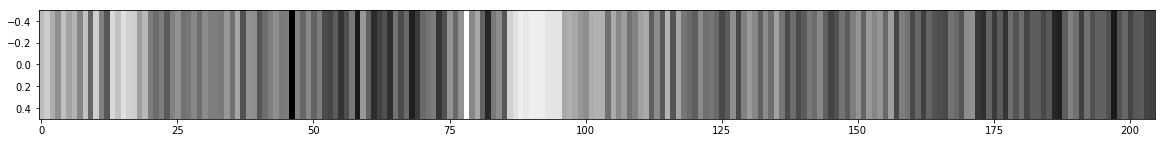

In [28]:
plt.figure(figsize = (20,2))
plt.imshow([np.diag(matrix)], cmap='gray', interpolation='nearest', aspect='auto')
plt.show()

In [141]:
# without bipos random_state=2652124
pd.DataFrame(list(zip(filtered.columns, np.diag(matrix))), columns=['feature', 'importance']).nlargest(300, 'importance')

,feature,importance
18,pos_freq_Vприч,1.000000
19,pos_freq_Vдеепр,1.000000
205,pos_ngram_freq_S_V_PR_S,1.000000
206,pos_ngram_freq_S_PR_A_S,1.000000
207,pos_ngram_freq_PR_S_PR_S,1.000000
208,pos_ngram_freq_S_PR_S_S,1.000000
209,pos_ngram_freq_V_PR_S_S,1.000000
210,pos_ngram_freq_S_S_S_S,1.000000
211,pos_ngram_freq_A_S_PR_S,1.000000
212,pos_ngram_freq_S_PR_S_V,1.000000


In [143]:
list(filtered.columns)

['avg_sent_len',
 'avg_word_len',
 'rel_voc_size',
 'hapax_legomena_freq',
 'pos_freq_A',
 'pos_freq_ADV',
 'pos_freq_ADVPRO',
 'pos_freq_ANUM',
 'pos_freq_APRO',
 'pos_freq_COM',
 'pos_freq_CONJ',
 'pos_freq_INTJ',
 'pos_freq_NUM',
 'pos_freq_PART',
 'pos_freq_PR',
 'pos_freq_S',
 'pos_freq_SPRO',
 'pos_freq_V',
 'pos_freq_Vприч',
 'pos_freq_Vдеепр',
 'char_freq_а',
 'char_freq_б',
 'char_freq_в',
 'char_freq_г',
 'char_freq_д',
 'char_freq_е',
 'char_freq_ж',
 'char_freq_з',
 'char_freq_и',
 'char_freq_й',
 'char_freq_к',
 'char_freq_л',
 'char_freq_м',
 'char_freq_н',
 'char_freq_о',
 'char_freq_п',
 'char_freq_р',
 'char_freq_с',
 'char_freq_т',
 'char_freq_у',
 'char_freq_ф',
 'char_freq_х',
 'char_freq_ц',
 'char_freq_ч',
 'char_freq_ш',
 'char_freq_щ',
 'char_freq_ъ',
 'char_freq_ы',
 'char_freq_ь',
 'char_freq_э',
 'char_freq_ю',
 'char_freq_я',
 'char_freq_А',
 'char_freq_Б',
 'char_freq_В',
 'char_freq_Г',
 'char_freq_Д',
 'char_freq_Е',
 'char_freq_Ж',
 'char_freq_З',
 'char

In [88]:
# without bipos random_state=2652123
pd.DataFrame(list(zip(filtered.columns, np.diag(matrix))), columns=['feature', 'importance']).nlargest(100, 'importance')

,feature,importance
94,char_freq_8,0.984416
95,char_freq_9,0.977238
92,char_freq_6,0.974333
87,char_freq_1,0.965478
90,char_freq_4,0.962609
88,char_freq_2,0.950287
89,char_freq_3,0.949929
93,char_freq_7,0.935317
91,char_freq_5,0.923657
13,pos_freq_PART,0.915802


In [68]:
np.array(filtered.columns)[np.argsort(np.diag(matrix))]

array(['bipos_freq_COM_Vприч', 'bipos_freq_COM_Vдеепр',
       'bipos_freq_SPRO_COM', 'bipos_freq_COM_A', 'bipos_freq_NUM_ANUM',
       'bipos_freq_INTJ_ANUM', 'bipos_freq_INTJ_Vприч',
       'bipos_freq_INTJ_PR', 'char_freq_Ц', 'bipos_freq_COM_SPRO',
       'bipos_freq_Vдеепр_Vприч', 'bipos_freq_COM_PART',
       'bipos_freq_ANUM_INTJ', 'bipos_freq_PR_COM', 'bipos_freq_COM_COM',
       'bipos_freq_SPRO_ANUM', 'bipos_freq_ANUM_V', 'bipos_freq_A_INTJ',
       'word_freq_дом', 'bipos_freq_Vдеепр_ANUM', 'bipos_freq_Vприч_ANUM',
       'word_freq_свое', 'bipos_freq_ANUM_Vприч', 'bipos_freq_INTJ_APRO',
       'bipos_freq_Vдеепр_PR', 'bipos_freq_ADV_ANUM',
       'bipos_freq_NUM_ADVPRO', 'bipos_freq_CONJ_ANUM',
       'bipos_freq_COM_ADVPRO', 'bipos_freq_ANUM_NUM',
       'bipos_freq_COM_CONJ', 'bipos_freq_Vприч_NUM', 'word_freq_стать',
       'bipos_freq_NUM_Vприч', 'char_freq_Г', 'bipos_freq_NUM_A',
       'char_freq_Ш', 'bipos_freq_NUM_INTJ', 'bipos_freq_ANUM_SPRO',
       'bipos_freq_NUM

In [79]:
pd.DataFrame(list(zip(filtered.columns, np.diag(matrix))), columns=['feature', 'importance']).nlargest(100, 'importance').feature

242     bipos_freq_ADVPRO_COM
273       bipos_freq_APRO_COM
287       bipos_freq_COM_ANUM
291       bipos_freq_COM_INTJ
292        bipos_freq_COM_NUM
321       bipos_freq_INTJ_COM
352       bipos_freq_PART_COM
432      bipos_freq_Vприч_COM
448     bipos_freq_Vдеепр_COM
90                char_freq_4
92                char_freq_6
89                char_freq_3
91                char_freq_5
93                char_freq_7
95                char_freq_9
15                 pos_freq_S
94                char_freq_8
186            word_freq_тута
13              pos_freq_PART
88                char_freq_2
87                char_freq_1
390            bipos_freq_S_S
16              pos_freq_SPRO
78                char_freq_Ъ
3         hapax_legomena_freq
17                 pos_freq_V
18             pos_freq_Vприч
4                  pos_freq_A
379            bipos_freq_S_A
226        bipos_freq_ADV_COM
104               char_freq_'
393        bipos_freq_S_Vприч
1                avg_word_len
10        

In [14]:
np.mean([0.414873348051,
0.383475827728,
0.376941880266,
0.393102217417,
0.403698204894,
0.421573729108])

0.39894420124400004

In [28]:
print(np.mean([0.470115465234,
0.482326013486,
0.457070172715,
0.475607266287,
0.487340603435,
0.513735345]), "with bipos, chunk_size 100000")

print(np.mean([0.546644082516,
0.555873155353,
0.526236507288,
0.539655493391,
0.566929519663,
0.565155590624]), "without bipos, chunk_size 100000")

print(np.mean([0.509705908879,
0.50898047938,
0.50964466772,
0.49936790951,
0.487686808668,
0.513048503265]), "only word_freq (mwf), chunk_size 100000")

print(np.mean([0.4497787059589852,
0.45014085597670067,
0.46906852315247993,
0.46713713494212916,
0.4716180977934367,
0.4343904195403546]), "without bipos on cleared corpus, chunk_size 50000")

0.481032477693 with bipos, chunk_size 100000
0.550082391473 without bipos, chunk_size 100000
0.504739046237 only freqs, chunk_size 100000


In [16]:
list(c.execute("""select a.name, count(distinct b.id) as ct from chunks_50000 c
        inner join words w on w.id = c.begin
        inner join books b on w.book = b.id
        inner join authors a on b.author = a.id
        group by a.name
        order by ct asc
        """))

[('Aksenov', 1),
 ('Belyaev', 1),
 ('Bulychev', 1),
 ('Doncova', 1),
 ('Dragunskiy', 1),
 ('Efremov', 1),
 ('Erenburg', 1),
 ('Kryukov', 1),
 ('Lermontov', 1),
 ('Pecuh', 1),
 ('Pelevin', 1),
 ('Popov', 1),
 ('Prishvin', 1),
 ('Reshetnikov', 1),
 ('Serafimovich', 1),
 ('Shargunov', 1),
 ('Troepolskiy', 1),
 ('Veller', 1),
 ('Voynovich', 1),
 ('Bazhov', 2),
 ('Bitov', 2),
 ('Chukovskiy', 2),
 ('Furmanov', 2),
 ('Gelasimov', 2),
 ('Gladkov', 2),
 ('Goncharov', 2),
 ('Grin', 2),
 ('Grossman', 2),
 ('Lazhechnikov', 2),
 ('Makarenko', 2),
 ('Matveeva', 2),
 ('Nagibin', 2),
 ('Oster', 2),
 ('Ostrovskiy', 2),
 ('Petrov', 2),
 ('Petrushevskaya', 2),
 ('Pogorelskiy', 2),
 ('Prokofeva', 2),
 ('Shalamov', 2),
 ('Shmelev', 2),
 ('Sokolov', 2),
 ('Vodolazkin', 2),
 ('Yuzefovich', 2),
 ('Akunin', 3),
 ('Aleksievich', 3),
 ('Astafev', 3),
 ('Averchenko', 3),
 ('Aytmatov', 3),
 ('Belov', 3),
 ('Bestuzhev-Marlinskiy', 3),
 ('Bondarev', 3),
 ('Charskaya', 3),
 ('Chehov', 3),
 ('Dobychin', 3),
 ('Dombrov

In [17]:
chunk_lexes_dfs = []
for book_id, author, book_name in list(c.execute("select id, author, name from books")):
    print(book_name)
    for chunk_id, chunk in enumerate(get_chunks(book_id, 50000)):
        chunk.lex.value_counts() /= chunk.lex.count()
        chunk_df['book'] = book_id
        chunk_df['chunk'] = chunk_id
        chunk_lexes_dfs.append(chunk_df)


SyntaxError: can't assign to function call (<ipython-input-17-8bbcf987e171>, line 5)

In [ ]:
chunk_lexes = pd.concat(chunk_lexes_dfs)

In [ ]:
chunk_lexes[:40000].book.value_counts().add(chunk_lexes[:20002].book.value_counts(), fill_value=0)

In [ ]:
lexes_crosstab = pd.crosstab(chunk_lexes.lex, [chunk_lexes.book, chunk_lexes.chunk_id], chunk_lexes.freq, aggfunc='sum', margins=True).fillna(0)

In [ ]:
mfw_freq = lexes_crosstab.drop('All').nlargest(500, 'All')

In [ ]:
chunk_str_names = ['%s_%s'%(book_name.split(".")[0], chunk_id) for book_name, author, book_id, chunk_id in chunk_names]
mfw_freq_csv = mfw_freq.loc[mfw_freq.]
mfw_freq_csv.columns = chunk_str_names
mfw_freq_csv

In [ ]:
mfw_freq.transpose().to_csv('mfw_freq.csv', header=False, index=False, sep='\t')

In [ ]:
chunk_freq_table = np.array([np.array([ct[w] for w in words]) for ct in chunk_word_counts])

In [ ]:
np.savetxt('freq_table.txt', chunk_freq_table, delimiter='\t')

In [ ]:
np.shape(chunk_freq_table)
normalized_chunk_freq_table = chunk_freq_table / np.sum(chunk_freq_table, axis=1, keepdims=True)

In [ ]:
popular_words_ix = np.argsort(np.sum(normalized_chunk_freq_table, axis=0))

In [ ]:
np.sum(normalized_chunk_freq_table, axis=0)

In [ ]:
stylo_cos_dists = pd.read_csv("file:///C:/Workspace/pb/stylo_cos_dists.csv")

In [ ]:
stylo_cos_dists_arr = np.array(stylo_cos_dists.drop([stylo_cos_dists.columns[0]], axis=1))

In [ ]:
stylo_dists = [[0 if i == j else 1000 for j in chunk_names] for i in chunk_names]
np.shape(stylo_dists)

In [ ]:
stylo_df = pd.read_csv("file:///C:/Workspace/pb/stylo_dists.csv")

In [ ]:
np.array(stylo_dists)

In [ ]:
get_r_prec(stylo_cos_dists_arr, feature_annot_frame)

In [ ]:
def model_dist(model):
    metric = model.metric()
    return lambda x, y: (x-y).dot(metric).dot(x-y)

def get_r_prec(test_dists, test_annot):
    test_labels = test_annot.author_id
    author_count = collections.Counter(test_labels)
    
    def get_dist_frame(i, dists):
        df = test_annot.copy()
        df['dist'] = dists
        to = test_annot.iloc[i]
        df['to_book_name'] = to.book_name
        df['to_author_id'] = to.author_id
        df['to_book_id'] = to.book_id
        df['to_chunk'] = to.chunk
        return df
    
    dist_frames = [get_dist_frame(i, dists) for i, dists in enumerate(test_dists)]
    #display(pandas.concat(dist_frames, axis=0))
    clipped_dist_frames = [df.nsmallest(author_count[df.to_author_id.iloc[0]], 'dist') for df in dist_frames]
    #display(pandas.concat(clipped_dist_frames, axis=0))
    r_precs = [(df.book_name.iloc[0],
                df.to_author_id.iloc[0],
                df.to_book_id.iloc[0],
                df.to_chunk.iloc[0],
                df[df.to_author_id == df.author_id].shape[0] - 1, #todo: do we count self match
                df.shape[0] - 1,
               ) for df in clipped_dist_frames]
    r_prec_frame = pandas.DataFrame(r_precs, columns=['book_name', 'author_id', 'book_id', 'chunk', 'found', 'should_have'])
    r_prec_frame['r_prec'] = r_prec_frame.found / r_prec_frame.should_have
    r_author_avg_r_prec_frame = r_prec_frame.groupby('author_id').mean()
    #display(r_author_avg_r_prec_frame)
    return r_author_avg_r_prec_frame.r_prec.mean()

def get_test_r_prec(model, test_features, test_annot):
    test_labels = test_annot.author_id
    non_singular_authors_indices = test_labels.duplicated(keep=False)
    test_features = test_features[non_singular_authors_indices]
    test_annot = test_annot[non_singular_authors_indices]
    test_dists = scipy.spatial.distance.cdist(test_features, test_features, model_dist(model))
    return get_r_prec(test_dists, test_annot)

In [ ]:




rkf = sklearn.model_selection.RepeatedKFold(n_splits=15, n_repeats=2, random_state=2652124)
for training_ix, test_ix in rkf.split(feature_annot_frame):
    cov = metric_learn.ITML_Supervised(num_constraints=200)
    cov.fit(np.array(normalized_feature_frame.iloc[training_ix]), np.array(feature_annot_frame.iloc[training_ix].author_id))
    print(get_test_r_prec(cov, normalized_feature_frame.iloc[test_ix], feature_annot_frame.iloc[test_ix]))
    break;

In [ ]:
group_texts = np.array(list(itertools.chain(*[[b for b in book_files if a == author(b)][:3] for a in author_counter if author_counter[a] >= 3])))
single_texts = np.array(sorted(set(os.listdir('json')) - set(training_and_test_set)))
g1, g2 = np.array_split(group_texts, 2)
s1, s2 = np.array_split(single_texts, 2)

training_and_test_set = np.append(g1, s1)
validation_set = np.append(g2, s2)

(len(training_and_test_set), len(validation_set))

In [ ]:
actual_distances = np.array([np.array([0.0 if author(b1) == author(b2) else 1.0 for b2 in book_files]) for b1 in book_files])

In [ ]:
def error_of_pair_grad(coeffs, i, j):
    book1, book2 = scaled_feature_matrix[[i, j]]
    sqr_diff = (book1 - book2) ** 2
    diff = np.dot(coeffs, sqr_diff) - actual_distances[i][j]
    
    return 2 * sqr_diff * diff

def error_of_all_pairs_grad(coeffs):
    return np.average(error_of_pair_grad(coeffs, i, j) for (i, j), d in np.ndenumerate(actual_distances))

def error_of_pair(coeffs, i, j):
    book1, book2 = scaled_feature_matrix[[i, j]]
    sqr_diff = (book1 - book2) ** 2
    diff = np.dot(coeffs, sqr_diff) - actual_distances[i][j]
    return diff ** 2 

def error_of_all_pairs(coeffs):
    print(coeffs[0:10])
    res = np.average(error_of_pair(coeffs, i, j) for (i, j), d in np.ndenumerate(actual_distances))
    print(res)
    return res

In [ ]:
#scipy.optimize.minimize(error_of_all_pairs, scaled_feature_matrix[0] * 0.0 + 0.01, method="CG", jac=error_of_all_pairs_grad)

In [ ]:
def get_feature_matrix_of_books(book_set):
    indices = [book_files.index(n) for n in book_set]
    return feature_matrix[indices]

training_and_test_features = sklearn.preprocessing.scale(get_feature_matrix_of_books(training_and_test_set))
training_and_test_authors = [author(b) for b in training_and_test_set]
print(np.shape(training_and_test_features), np.shape(training_and_test_authors))
training_and_test_labels = np.array([training_and_test_authors.index(a) for a in training_and_test_authors])

In [ ]:
training_ix = np.arange(len(g1))
test_ix = np.array(sorted(set(training_and_test_ix) - set(training_ix)))

In [ ]:
cov = metric_learn.Covariance()

cov.fit(training_and_test_features[training_ix], training_and_test_labels[training_ix])

In [ ]:
lmmn = metric_learn.LMNN(k=1, learn_rate=0.01)
lmmn.fit(training_and_test_features, training_and_test_labels)

In [ ]:
sdml = metric_learn.ITML_Supervised(num_constraints=200)
sdml.fit(training_and_test_features, training_and_test_labels)

In [ ]:
model = sdml

In [ ]:
test_features = training_and_test_features[test_ix]
test_set = training_and_test_set[test_ix]
test_dists = np.array([[model_dist(model)(f1, f2) for f1 in test_features] for f2 in test_features])

In [ ]:
test_ix

In [ ]:
np.shape(test_dists)

In [ ]:
def get_r_score(titles, dists):
    expected_matches_counts = [len([t2 for t2 in titles if author(t1) == author(t2) and t1 != t2]) for t1 in titles]
    clipped_neighbours = np.array([row.argsort()[1:r+1] for row, r in zip(dists, expected_matches_counts)])
    real_neighbour_count = np.array([len([t for t in titles[found_neighbours] if author(t) == author(title)]) for found_neighbours, title in zip(clipped_neighbours, titles)])
    authors = collections.Counter(map(author, titles))
    coeffs = np.array([authors[author(t)] for t in titles])
    individual_r_scores = real_neighbour_count / expected_matches_counts
    non_singular_authors = [a for a in authors if authors[a] > 1]
    return sum(c for c in individual_r_scores / coeffs / len(non_singular_authors) if not np.isnan(c))

In [ ]:
get_r_score(test_set, test_dists)